# Fruits Project 


## DataSet overview

## Import Libraries

In [45]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np

# TensorFlow and Keras
import tensorflow as tf

from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import models

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet50V2



## Global Variables

In [46]:
SEED = 42
BATCH_SIZE = 32 
IMG_SIZE = (224, 224)
EPOCHS = 10
IMAGE_SIZE_TARGET = (128, 128)

### Check GPUs

In [47]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Load Data

In [48]:
def split_data_by_class(source_dir, train_dir, val_dir, train_size=0.8, seed=42):
    np.random.seed(seed)

    # Make sure output folders exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # For each class folder
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        np.random.shuffle(images)

        split_idx = int(train_size * len(images))
        train_imgs = images[:split_idx]
        val_imgs = images[split_idx:]

        # Create class dirs in target folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        for img in val_imgs:
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )


# Original train folder
original_train = "fruits-360/Training"

# New train and val folders
new_train = "fruits-360/Train_Split"
val = "fruits-360/Val"

# Split
split_data_by_class(original_train, new_train, val, train_size=0.7)


train_ds = image_dataset_from_directory(
    "fruits-360/Train_Split",
    image_size=(128, 128),
    batch_size=32,
    seed=42,
    shuffle=True,
    # label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    "fruits-360/Val",
    image_size=(128, 128),
    batch_size=32,
    seed=42,
    shuffle=True,
    # label_mode="categorical"
)

test_ds = image_dataset_from_directory(
    "fruits-360/Test",
    image_size=(128, 128),
    batch_size=32,
    seed=42,
    shuffle=False,
    # label_mode="categorical"
)


Found 71708 files belonging to 200 classes.
Found 30828 files belonging to 200 classes.
Found 34230 files belonging to 200 classes.


In [49]:
len(train_ds), len(val_ds), len(test_ds), len(train_ds.class_names), len(val_ds.class_names), len(test_ds.class_names)
# (2241, 964, 1070, 200, 200, 200)

(2241, 964, 1070, 200, 200, 200)

ALL of the sets have all the classes into it 

The train has the heighest number of data > val

2025-05-18 17:59:35.467318: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


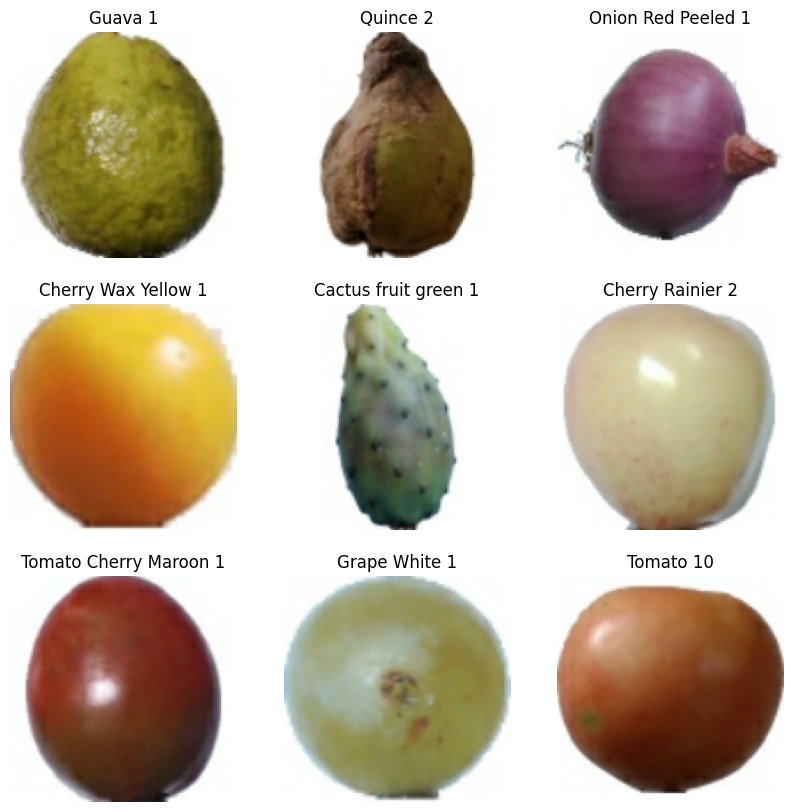

In [50]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Preprocessing

In [54]:
def preprocess(image):
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0
    return image

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

def prepare_dataset(dataset):
    dataset = dataset.map(lambda x, y: (preprocess(x), y))
    dataset = dataset.map(augment)
    # dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Apply preprocessing and augmentation to datasets
train_ds_prepared = prepare_dataset(train_ds)
val_ds_prepared = prepare_dataset(val_ds)
test_ds_prepared = prepare_dataset(test_ds)


## Model

In [56]:
# Load the ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds_prepared,
    validation_data=val_ds_prepared,
    epochs=10
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds_prepared)

print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Train accuracy: {history.history['accuracy'][-1]:.2f}")
print(f"Loss: {test_loss:.2f}")

Epoch 1/10


I0000 00:00:1747580644.192032  105601 service.cc:152] XLA service 0x707ee8003c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747580644.192099  105601 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-05-18 18:04:04.635887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747580648.860326  105601 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-18 18:04:12.987864: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5194', 204 bytes spill stores, 204 bytes spill loads

2025-05-18 18:04:13.425739: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

   1/2241 ━━━━━━━━━━━━━━━━━━━━ 24:49:26 40s/step - accuracy: 0.0000e+00 - loss: 5.8951

I0000 00:00:1747580670.584225  105601 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2240/2241 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2643 - loss: 3.5850

2025-05-18 18:08:02.320261: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5194', 220 bytes spill stores, 220 bytes spill loads

2025-05-18 18:08:02.332937: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5194', 8 bytes spill stores, 8 bytes spill loads

2025-05-18 18:08:02.910234: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7729', 28 bytes spill stores, 32 bytes spill loads

2025-05-18 18:08:03.563060: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5194', 4384 bytes spill stores, 4228 bytes spill loads

2025-05-18 18:08:04.169462: I extern

2241/2241 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2644 - loss: 3.5845

2025-05-18 18:08:20.725540: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-05-18 18:09:59.089231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1504', 12 bytes spill stores, 12 bytes spill loads

2025-05-18 18:09:59.198955: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1504', 8 bytes spill stores, 8 bytes spill loads

2025-05-18 18:09:59.694914: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

2241/2241 ━━━━━━━━━━━━━━━━━━━━ 378s 151ms/step - accuracy: 0.2645 - loss: 3.5840 - val_accuracy: 0.8908 - val_loss: 0.7027
Epoch 2/10
   2/2241 ━━━━━━━━━━━━━━━━━━━━ 3:23 91ms/step - accuracy: 0.6875 - loss: 1.0503 

2025-05-18 18:10:08.462941: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 589/2241 ━━━━━━━━━━━━━━━━━━━━ 2:38 96ms/step - accuracy: 0.7207 - loss: 1.0671